<a href="https://colab.research.google.com/github/srirampattabiraman/Computer-vision/blob/master/Bad_network_for_MNIST_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Not an ideal network**

The cell below does the following:

- It issues a **shell command** to install the keras module into the python environment that this notebook is supposed to run in
- It imports the keras module into the program written in this notebook

The **!** symbol is used in notebooks to issue **shell commands**. The **shell** is an typed interface to a computer. One could use shells like the *bash* (UNIX based systems) or *powershell* (Windows based systems) to execute binaries, move files and folders and what have you.

A **python module** is synonymous to a library in other programming language. It is the grouping of multiple classes and methods under a namespace. When imported to another program, these methods and classes can be used in the programusing the syntax:
    
    <module_name>.<class/method_name>
    
A **python environment** is simply a fancy name for the runtime. It includes the python interpreter, the site-packages, a set of binaries like pip, pip3 etc and ofcourse the packages that were manually installed. Environments are used to maintain repeatability of behaviour of code and facilitate collaboration among programmers.

**Keras** is an open source wrapper API using Google's tensorflow framework. It helps to think of *keras* as an easy way to build neural networks and perform mathematical computation using the tensorflow backend.

**Tensorflow** is an opensource mathematical computation framework that operates on predefined computational graphs. It was developed and is maintained by Google and is one of the most hit repositories on GitHub.



In [0]:
# https://keras.io/
!pip install -q keras
import keras

The block of code below imports classes and methods and whole python modules into the runtime. We shall go through each one of the imports and see why we have imported them:

- **numpy** : NumPy is a python library used for mathematical computation. Machine learning frameworks like Tensorflow, Pythorch etc. interface very well with numpy. Inout is served to the ML frameworks using NumPy arrays and the frameworks variables and constants can be converted to numpy N-D arrays. Hence it is a very handy tool to have

- **Sequential** : Sequential is a class defined in keras. It is a blueprint for a model consisting of layers stacked on top of each other in a *linear order*. It does not permit branching from any of it's layers. ([Link to documentation](https://keras.io/getting-started/sequential-model-guide/)) 

- **Flatten** : Flatten is a class defined in keras that implements a Layer ADT (Abstract Datatype). A Layer is a class that defines a set of functions - forward and backward for example. Flatten is a Layer whose forward pass takes an input of size *(batch_size, num_channels, height, width)* and flattens the last three dimentions resulting in a tensor of shape *(batch_size, num_channels * height * width)*. Well to be fair it only creates a tensorflow Op that actuates the flatten operation([Link to documentation](https://keras.io/layers/core/))

- **Convolution2D** - This is again a Layer which expects as input an Image of shape *(batch_size, num_channels, height, width)* and kernel parameters in the order *num_filters, height, width*. It creates a tensorflow operation that convolves the filter on the Image and outputs the result in the shape *batch_size, height, width* - You can also pass in the weight initialization information, a switch for adding the bias, regularization parameters etc. ([Link to documentation](http://faroit.com/keras-docs/1.2.2/layers/convolutional/))

- **np_utils** : These provide a ton on awesome and generally used methods for building the data-pipeline. The one we are interested in today is the *to_categorical* method that takes as input an inout array of shape *(batch_size)* where each value belongs to the set N[0, num_classes - 1] where N stands for the set of Natural numbers and converts it to a one - hot format - a tensor of shape *(batch_size, num_classes)*. The *one hot* format encodes the class label*(L)* as a pulse (A zero vector *v* of shape *(num_classes)* where only v[L] = 1.0)

- **mnist** : It is a dataset comprising of 60,000 *(1, 28, 28)* shape greyscale images of handwritten digits. The static *load_data*  method of mnist returns 2 numpy arrays of shape *(num_samples, 28, 28)* representing the train and the test sets and 2 numpy arrays of shape *(num_samples)* representing the train and test labels. The trainset comprises of 50,000 examples and the testset comprises of 10,000 examples. ([Link to documentation](https://keras.io/datasets/))

In [0]:
import numpy as np

from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Convolution2D
from keras.utils import np_utils

from keras.datasets import mnist

The code below loads the images and labels belonging to the mnist dataset into numpy arrays. Well, it's actually not all that simple. To appreciate what the *mnist.load_data()* method has abstracted away - let's dig a little deeper:

- **Download the data** : For one, the actual files containing the images and the labels are not in the system where this program is running.  The method actually takes an argument called *PATH* that is by default an empty string. It looks up the system at <~/keras/datasets/ + PATH> for the image and label files and if not found it downloads them from the internet and stores them at that location. All non-existent directories are created on the go.

- **Convert images to arrays** : Well what gets downloaded is a *.npz* file - this is numpys way of storing arrays encountered during the runtime as tar.gz files. NumPy provides I/O utilities for these kind of files. Hence, after downloading the .npz files the method loads them into the runtime as numpy arrays

- **Returns the arrays** : The arrays thus loaded of shapes X_train(60000, 28, 28), y_train(60000), X_test(10000, 28, 28) and y_test(10000) are packed in tuples as ((X_train, y_train),(X_test,y_test)) and returned from the method 

In [0]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

The code below does the following:

- **Printing the shape of the training images** : X_train.shape prints out the shape of the numpy ND array X_train. A shape is a property of a numpy ND array object that packs the lengths of each of it's dimentions into a tuple. In this case, the shape is *(60000, 28, 28)* standing for *(batch_size, height, width)*

- **Imports matplotlib.pyplot** : This is a plotting module used with python to plot graphs, summary plots, images and what have you.

- **Plots the first example of the training set** : Here the code uses *matplotlib.pyplot.imshow()* method to plot the 0th element of X_train which is the first training image.

*PS : %matplotlin inline is a rendering directive to matplotlib to use the console to print the plot and not a separate window*

(60000, 28, 28)


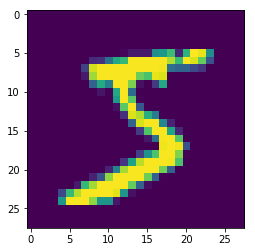

In [0]:
print (X_train.shape)
from matplotlib import pyplot as plt
%matplotlib inline
plt.imshow(X_train[0])

The code below simply reshapes the train and test sets of images - variables named *X_train* and *X_test* respectively. Why?

Well it so happens that under the hood the *Convolution2D* layer that we imported earlier calls the tensorflow.nn.conv2D() method to create a convolution operation node in the computational graph on the network.

[This operation](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d) takes an argument called data_format which defaults to *'NHCW'* - meaning that the inoput is expected in the shape *[batch_size, height, width, num_channels]*

Since mnist Images are greyscale - they contain only one color channel which we make explicit when reshaping X_train and X_test to *(train/test_set_size, 28, 28, 1)*

- X_train[0] --> train_set_size
- X-test[0] --> test_set_size 

In [0]:
X_train = X_train.reshape(X_train.shape[0], 28, 28,1)
X_test = X_test.reshape(X_test.shape[0], 28, 28,1)
print(type(X_train[0,0,0,0]))

<class 'numpy.uint8'>


The code below performs the following actions:

###Type Conversion

X_train and X_test are currently of type *numpy.uint8* which is a numpy wrapper over the unsigned 4-byte integer python datatype. We convert them to *numpy.float32* for the following reasons

- The *tensorflow.nn.conv2d* operation expects the input tensor to be of *tf.half*, *tf.bfloat*, *tf.float32* or *tf.float64* datatypes and numpy arrays of datatype *uint32* arent convertible to any of these datatypes. Hence, we convert the input to type *np.float32* in the code below.

- We need to scale the pixels of the image within the range R[0,1] where R stands for the set of real numbers and integer division just wont work.

###Input Scaling

Okay then .. why scale at all? Well think of it this way the *SGD* algorithm used to train neural networks uses the gradient of the loss w.r.t the kernels to train / update them for the next batch. Therefore, the delta in the kernel values would be proportional to the gradients which in turn would be a function of the input values.

Alright - so if we permit a range between R[0.0, 255.0], we are also permitting a wide range of gradients - Hence the correction for not detecting a llight edge would be significantly smaller than the correction for not detecting a bright edge and this is the behaviour we want to eliminate from our networks. Our judgement of an error should be agnostic to the intensity of the input - and hence we scale down to R[0,1]

Well, we've added code to ensure that the scaling has not messed up with out features - Plotting the image, we see the more or less look the same before and after scaling.


In [0]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

The code below prints the first ten labels contained in the y_train array. They represent the labels for the first 10 images of the train set

In [0]:
y_train[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

### Towards One-Hot ... ness??

One hot vectors are zero vectors used to represent a set of natural numbers each belonging to a certain range named *num_classes*.

So, if :

- number = 3
- num_classes = 10
- one_hot_number = [0, 0, 0, 3, 0, 0, 0, 0, 0, 0]

The *np.to_categorical* method expects input  of a numpy array in the shape *[batch_size]* and a positive integer called *nb_classes* and outputs a 2D array of shape *[batch_size, nb_classes]* where each element in the input *I[k]* in represented by the corensonding output row *O[k,:]*

*PS : It apparently converts datatype to np.float32 as well*

###Why one_hot at all?

We use this encoding since it helps us calculate losses for all classes separately. Calculating losses in this manner helps us backpropagate gradients for errors in detecting all classes instead of just the input class.

In [0]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

The code below prints the first 10 elements of Y_train which is the one-hot encoding of the y_train vector that represent the training labels

In [0]:
Y_train[:10]


array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

###Defining the model

The following code defines the architecture / model of our neural network. At this stage - we define the operations of the network *(i.e. adding the layers of the network to a pre-defined keras model)*

- **Initializing a sequential model** : A Sequential model in keras stacks layers on top of one another. It makes sure that the input and outbut sizes of successive layers are compatible. In the first LOC below - we initialize an instance of the Sequential class.

- **Adding convolution layers** : Now that we have initialized our model - we start adding layers. What we add to the sequential model are instances of the Convolution2D class defined in keras. While adding the first convolution layer we need to specify the input size *(height, width, num_channels)* as well. The next layers do not need an input size since they assume they will be in the shape of the preceeding layers model. We can also specify as an argument the activation to be used. *Default Stride = 1, pool_size = (3, 3), output_size = (batch_size, input_size - 2, output_size - 2, num_channels)*

- **Adding Max Pooling layers** : Next, we add max pooling layers to reduct the first two dimentions of each image. This layer extracts the maximuim out of the *(2, 2)* pool and passes them forward - The output size would be *(input_size // 2, input_size // 2, num_channels)*

- **Adding Flatten layers** : Finally, when we reach a GRF of the whole image *(1, 1, num_channels)*, we flatten the output *channel-wise* into an output of shape *(batch_size, 10)*. We also add a relu activation on top

- **Adding the softmax layers** : Softmax layers implement a differentiable maximum function. Given a vector of elements *<v[1] ... v[n]>* if makes the following operation: *v[i] = e^(v[i]) / sum(e^v[k]) for all k in range [1,n]*. This converts the activations of the last layer into a probability distribution

Following EVA conventions, we now note down the layers in the following manner:

*batch_size --> b_s*

- [b_s, 28, 28, 1] | Conv2D - [3, 3, 32] |  [b_s, 26, 26, 32],
- [b_s, 26, 26, 32] | Conv2D - [3, 3, 64] | [b_s, 24, 24, 64]
- [b_s, 24, 24, 64] | Conv2D - [3, 3, 128] | [b_s, 22, 22, 128]
- [b_s, 22, 22, 128] | MaxPooling - [2, 2] | [b_s, 11, 11, 128]
- [b_s, 11, 11, 128] | Conv2D - [3, 3, 256] | [b_s, 9, 9, 256]
- [b_s, 9, 9, 256] | Conv2D - [3, 3, 512] | [b_s, 7, 7, 512]
- [b_s, 7, 7, 512] | Conv2D - [3, 3, 1024] | [b_s, 5, 5, 1024]
- [b_s, 5, 5, 1024] | Conv2D - [3, 3, 2048] | [b_s, 3, 3, 2048]
- [b_s, 3, 3, 2048] | Conv2D - [3, 3, 10] | [b_s, 1, 1, 10]
- [b_s, 1, 1, 10] | Flatten | [b_s, 10]
- [b_s, 10] | Softmax | [b_s, 10]

The discourse in the class still maintains that max pooling doubles the receptive feild - however - we can figure this out ourselves - by giving iot a little thought. 

[This image](https://github.com/anubhavsatpathy/EVA/blob/master/Session2/rf_max_pool.png) provides proof that a 2x2 max pool layer ups the GRF by 1 per dimention and thereafter, every 3x3 convolution layers increases the GRF by 4 - The comments in the block below follow this logic to list down the GRF values of the inputs in each layer



In [0]:
from keras.layers import Activation, MaxPooling2D

# All shapes are in the form [batch_size, height, width, num_channels]

model = Sequential() 

# INPUT SIZE : [batch_size, 28, 28, 1] | OUTPUT SIZE : [batch_size, 26, 26, 32] | GRF_of_input : [1, 1]
model.add(Convolution2D(32, 3, 3, activation='relu', input_shape=(28,28,1)))
# INPUT SIZE : [batch_size, 26, 26, 32] |  OUTPUT SIZE : [batch_size, 24, 24, 64] | GRF_of_input : [3, 3]
model.add(Convolution2D(64, 3, 3, activation='relu'))
# INPUT SIZE : [batch_size, 24, 24, 64] | OUTPUT SIZE : [batch_size, 22, 22, 128] | GRF_of_input : [5, 5]
model.add(Convolution2D(128, 3, 3, activation='relu'))
# INPUT SIZE : [batch_size, 22, 22, 128] | OUTPUT SIZE : [batch_size, 11, 11, 128] | GRF_of_input : [7, 7]
model.add(MaxPooling2D(pool_size=(2, 2)))
# INPUT SIZE : [batch_size, 11, 11, 128] | OUTPUT SIZE : [batch_size, 9, 9, 256] | GRF_of_input : [8, 8]
model.add(Convolution2D(256, 3, 3, activation='relu'))
# INPUT SIZE : [batch_size, 9, 9, 256] | OUTPUT SIZE : [batch_size, 7, 7, 512] | GRF_of_input : [12, 12]
model.add(Convolution2D(512, 3, 3, activation='relu'))
# INPUT SIZE : [batch_size, 7, 7, 512] | OUTPUT SIZE : [batch_size, 5, 5, 1024] | GRF_of_input : [16, 16]
model.add(Convolution2D(1024, 3, 3, activation='relu'))
# INPUT SIZE : [batch_size, 5, 5, 1024] | OUTPUT SIZE : [batch_size, 3, 3, 2048] | GRF_of_input : [20, 20]
model.add(Convolution2D(2048, 3, 3, activation='relu'))
# INPUT SIZE : [batch_size, 3, 3, 2048] | OUTPUT SIZE : [batch_size, 1, 1, 10] | GRF_of_input : [24, 24]
model.add(Convolution2D(10, 3, 3, activation='relu'))
# INPUT SIZE : [batch_size, 1, 1, 10] | OUTPUT SIZE : [batch_size, 10] | GRF_of_input : [28, 28]
model.add(Flatten())
# INPUT SIZE : [batch_size, 10] | OUTPUT SIZE : [batch_size, 10] | GRF_of_input : [28, 28]
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_58 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 22, 22, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 11, 11, 128)       0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 9, 9, 256)         295168    
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 7, 7, 512)         1180160   
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 5, 5, 1024)        4719616   
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1...)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), activation="relu")`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), activation="relu")`
/usr/local/lib/python3.6/dist-packages/ipy

### Compiling the model:

Compiling the model means that keras will actually create the computational graph using tensorflow backend. For this to happen, we need to provide a loss function and an optimizer and an accuracy metric. We define this as below:

- **Loss Function** : A loss function is a mathematical function that calculates some sort of differentiable distance measure between the network's output and the actual output for each class. During training, we average out these losses and backpropagate them through the network. In this case - we use categorical cross-entropy

- **Optimizer** : This step selects an optimizer algorithm that manipulates the learning rate per time-step so as to update the weights in a manner that does not lead to a swinging behaviour around the minimum. A few examples are *AdaGrad, Momentum etc*. but *Adam* has long been established as the king of the jungle

- **Accuracy Metric** : This is a metric that measures the performance of the network. In the case of classification this is accuracy *(i.e. number_of_correct_predictions / number_of_total_examples_in_batch)*. Well there are other measures as well like BLEU score in case of machine translation etc.

*model.compile() sets things up for us before we start training the model*

###Categorical Cross Entropy:

*Cross_Entropy = sum(-t[i] * log[l[i]] - (1 - t[i]) * log(1 - l[i]))*

where :

- *i* belongs to range *N[0, num_classes]*
- *t[i]* --> prediction for class *i*
- *l[i]* --> label for class *i*

|t[i]   |v[i]   |CE[i]   |
|---|---|---|
|   1.0|   0.01|  4.55 |
|   1.0|   0.05|   2.30|
|   1.0|   0.95|   0.23|
|   0.0|   0.01|   0.05|
|   0.0|   0.5|   2.30|
|   0.0|   0.95|   4.37|

As can be seen in the table above - this decreases as the predictions come closer to labels and increases as they grow apart

In [0]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

### Training the model:

Training examples are fed to a network in batches - this is called minibatch Gradient Descent instead of fullbatch Gradient Descent. There are subtle mathematical differences b/w minibatch and fullbatch versions but minibatch Gradient Descent has proved to be a winner in two aspects:

- It consumes less memory and is operationally more efficient
- It does not give up too much on the accuracy of the network

Hence, we need a *batch_size* - we pass this as an argument to the *Sequential.fit()* method - In this case we pass *32*

An *epoch* is the number of batches passed through the network before having covered the full training set.

The *number of epoch* we want to train the network is again passed to the same method as an argument - In this case 10

We also pass the training images and training labels to the fit method - The method breaks them down into batches and passes them through the network - calculates losses and backpropagates gradients for each batch.

*FORM CURRENT BATCH --> PASS THROUGH THE NETWORK --> CALCULATE LOSSES --> BACKPROPAGATES GRADIENTS*

It does the above functions for each batch in each epoch.

X_train has to be in the shape *[num_examples, height, width, num_channels]*

After training 60,000 images for 10 epochs using batch sizes of 32:

- Losses stayed at around 2.30
- Accuracy stayed at around 9%

Wait what!

In [0]:
model.fit(X_train, Y_train, batch_size=32, nb_epoch=10, verbose=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Epoch 1/10
60000/60000 [==============================] - 117s 2ms/step - loss: 2.3028 - acc: 0.0986
Epoch 2/10
60000/60000 [==============================] - 114s 2ms/step - loss: 2.3026 - acc: 0.0987
Epoch 3/10
60000/60000 [==============================] - 114s 2ms/step - loss: 2.3026 - acc: 0.0987
Epoch 4/10
60000/60000 [==============================] - 114s 2ms/step - loss: 2.3026 - acc: 0.0987
Epoch 5/10
60000/60000 [==============================] - 114s 2ms/step - loss: 2.3026 - acc: 0.0987
Epoch 6/10
60000/60000 [==============================] - 114s 2ms/step - loss: 2.3026 - acc: 0.0987
Epoch 7/10
60000/60000 [==============================] - 114s 2ms/step - loss: 2.3026 - acc: 0.0987
Epoch 8/10
60000/60000 [==============================] - 114s 2ms/step - loss: 2.3026 - acc: 0.0987
Epoch 9/10
60000/60000 [==============================] - 115s 2ms/step - loss: 2.3026 - acc: 0.0987
Epoch 10/10
60000/60000 [==============================] - 114s 2ms/step - loss: 2.3026 - a

In [0]:
score = model.evaluate(X_test, Y_test, verbose=1)

In [0]:
print(score)

[2.3025851249694824, 0.098]


In [0]:
y_pred = model.predict(X_test)

In [0]:
print(y_pred[:9])
print(y_test[:9])

[[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]]
[7 2 1 0 4 1 4 9 5]


###Not Ideal Indeed

Since the losses are not decreasing aften 10 epochs and neither is the accuracy going up we can clearly say our network is upto no good. Why?

- **Loss of information in the last layer** :  The last convolution layer brings down 2048 * 3 * 3 elements used to represent features of the image directly down to 10 * 1 * 1 features - thats a 99.945 % loss in information - no wonder we messed up. What happens if we undertake such a massive drop in information is that the gradients comin in get distributed across a ton of weights thus each weight is hardly if at all updated - Hence no learning

- **ReLU in last layer** : Adding the ReLU activation in the last layer makes it much tougher for the network to learn class activations. Think of similar images like 5 and 2 that will have similar positive activations but the disparioty is contained in the negative activations - These disparities will dissappear after ReLU making it even tougher for the network to learn. (Disclaimer - This was added after the Thursday class wherein this was discussed)

- **Lack of a bottleneck** : The max pooling layer should ideally be followed by a 1 * 1 convolution layer to shrink the number of channels and then begin the process of discriminating the next set of features in this case - the numbers themshelves

- **Too many parameters** : 25,348,362 trainable parameters take a ton more time to train

-  **Too many convolution** : We decreased the size of the last output of convolution to [1, 1] - This space is just too little to represent any information at all  about the numbers - remember convolutions detect information by representing them in the output layer using the features detected by the kernels - sizes like 3*3 and 1*1 just are not enough to represent these visual information about numbers

- **Early Max-Pooling** : The max-pooling happens when the GRF is [7, 7] - most edges are visible at a receptive field of [9, 9] of [11, 11]. Well, I say that with a pinch of salt for the image size of this dataset is rather small

- **Lack of normalization** : It is usually wise to normalize the layers after every few convolution layers - hence not ensuring that the activations are not flying all haywire

We changed a few things about the network - let's see how it performs now:

- **Training Accuracy** : 99.23% %
- **Training Loss** : 0.03


In [0]:
from keras.layers import Activation, MaxPooling2D
from keras.layers import BatchNormalization

model1 = Sequential()
model1.add(Convolution2D(32, 3, 3, activation='relu', input_shape=(28,28,1)))
model1.add(Convolution2D(64, 3, 3, activation='relu'))
model1.add(Convolution2D(128, 3, 3, activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Convolution2D(32, 1, 1, activation = 'relu'))
model1.add(Convolution2D(64, 3, 3, activation = 'relu'))
model1.add(Convolution2D(128, 3, 3, activation = 'relu'))
model1.add(BatchNormalization())
model1.add(Convolution2D(256, 3, 3, activation = 'relu'))
model1.add(Convolution2D(128, 3, 3, activation = 'relu'))
model1.add(Convolution2D(10, 3, 3, activation = 'relu'))
model1.add(Flatten())
model1.add(Activation('softmax'))
model1.summary()

model1.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

model1.fit(X_train, Y_train, batch_size=100, nb_epoch=10, verbose=1)

score = model1.evaluate(X_test, Y_test, verbose=1)
print(score)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1...)`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1), activation="relu")`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_110 (Conv2D)          (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_111 (Conv2D)          (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_112 (Conv2D)          (None, 22, 22, 128)       73856     
_________________________________________________________________
batch_normalization_9 (Batch (None, 22, 22, 128)       512       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 11, 11, 128)       0         
_________________________________________________________________
conv2d_113 (Conv2D)          (None, 11, 11, 32)        4128      
_________________________________________________________________
conv2d_114 (Conv2D)          (None, 9, 9, 64)          18496     
__________